In [74]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from nltk.corpus import stopwords
import nltk


In [107]:
file_path = 'apartments_for_rent_classified_100K.csv' 
try:
    data = pd.read_csv(file_path , encoding='windows-1252' , sep = ';')
    print(f"file found and data read successfully")
except:
    print("File not found")

file found and data read successfully


C:\Users\wisen\AppData\Local\Temp\ipykernel_38940\784373476.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path , encoding='windows-1252' , sep = ';')


In [108]:
df = data.copy(deep=True)

In [77]:
df.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9.949200e+04,99429.000000,99368.000000,99491.000000,99492.000000,99467.000000,99467.000000,9.949200e+04
mean,5.358321e+09,1.445323,1.728212,1527.057281,956.430688,36.947988,-91.568656,1.559665e+09
std,1.847404e+08,0.547021,0.749200,904.245882,417.571522,4.599461,15.817168,1.105077e+07
min,5.121046e+09,1.000000,0.000000,100.000000,101.000000,19.573800,-159.369800,1.544174e+09
25%,5.197950e+09,1.000000,1.000000,1013.000000,729.000000,33.746500,-104.791900,1.550832e+09
50%,5.508673e+09,1.000000,2.000000,1350.000000,900.000000,37.228200,-84.562300,1.568745e+09
75%,5.509007e+09,2.000000,2.000000,1795.000000,1115.000000,39.953000,-77.608200,1.568767e+09
max,5.669439e+09,9.000000,9.000000,52500.000000,50000.000000,64.833200,-68.778800,1.577391e+09


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99492 non-null  int64  
 1   category       99492 non-null  object 
 2   title          99492 non-null  object 
 3   body           99492 non-null  object 
 4   amenities      83448 non-null  object 
 5   bathrooms      99429 non-null  float64
 6   bedrooms       99368 non-null  float64
 7   currency       99492 non-null  object 
 8   fee            99492 non-null  object 
 9   has_photo      99492 non-null  object 
 10  pets_allowed   39068 non-null  object 
 11  price          99491 non-null  float64
 12  price_display  99491 non-null  object 
 13  price_type     99492 non-null  object 
 14  square_feet    99492 non-null  int64  
 15  address        7943 non-null   object 
 16  cityname       99190 non-null  object 
 17  state          99190 non-null  object 
 18  latitu

In [79]:
###missing value df 
missing_df = pd.notna(df)
missing_df.head()


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [109]:
####Missing values per column in the dataframe, needs to be improved to look better
percentage_missing_array = []
missing_values_array = []
column_names = [df.columns]

for x in df.columns:
    missing_values = df[x].isna().sum()
    missing_values_array.append(missing_values)
    percentage_missing = df[x].isna().mean()
    percentage_missing_array.append(percentage_missing*100)
    #print(f"{x} , Missing_values- {missing_values} - percentage - {percentage_missing*100} ")

missing_df = pd.DataFrame({
    'Column_Name': df.columns,
    'Missing_Values': missing_values_array,
    'Percentage_Missing': percentage_missing_array
})

missing_df.head()

condition = missing_df['Percentage_Missing']>0.1
##### this is looking at columns with data that is missing and its more than 10% 

filtered_df = missing_df[condition ]
print(filtered_df)

     Column_Name  Missing_Values  Percentage_Missing
4      amenities           16044           16.125920
6       bedrooms             124            0.124633
10  pets_allowed           60424           60.732521
15       address           91549           92.016444
16      cityname             302            0.303542
17         state             302            0.303542


In [110]:
columns_to_drop = ['address']
df = df.drop(columns= columns_to_drop , axis= 1)
df.columns

Index(['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms',
       'currency', 'fee', 'has_photo', 'pets_allowed', 'price',
       'price_display', 'price_type', 'square_feet', 'cityname', 'state',
       'latitude', 'longitude', 'source', 'time'],
      dtype='object')

In [111]:
df['pets_allowed'] = df['pets_allowed'].fillna('no_pets_allowed')
#df['pets_allowed'] = df['pets_allowed'].str.strip()

#for i in range(len(df['pets_allowed'])):
#  if df['pets_allowed'][i] == 'Cats,Dogs':
#        df['pets_allowed'][i] = 'both'
#    elif df['pets_allowed'][i] == 'Cats,Dogs,None':
#        df['pets_allowed'][i] = 'Not_sure'
#    else:
#        df['pets_allowed'][i]


df['pets_allowed'] = df['pets_allowed'].replace({
    'Cats,Dogs': 'Both',
    'Dogs,Cats': 'Both',
    'Cats,Dogs,None': 'NotSure',
    'no_pets_allowed': np.nan
})

df['pets_allowed'].value_counts()

pets_allowed
Both       37097
Cats        1843
Dogs         127
NotSure        1
Name: count, dtype: int64

In [113]:
df['bedrooms'] = df['bedrooms'].fillna(0)
df['bedrooms'].value_counts()

bedrooms
2.0    45975
1.0    40331
3.0    10561
4.0     1498
0.0      786
5.0      286
6.0       47
7.0        4
8.0        3
9.0        1
Name: count, dtype: int64

In [114]:
#### grouping this is showing me that the data has some type of multiclassification that i can do 
df.groupby('amenities').size()

amenities
AC                                                                                                                                 264
AC,Alarm,Basketball,Cable or Satellite,Clubhouse,Dishwasher,Gated,Gym,Hot Tub,Parking,Playground,Pool,Refrigerator,Washer Dryer      3
AC,Alarm,Basketball,Cable or Satellite,Clubhouse,Dishwasher,Gated,Gym,Hot Tub,Playground,Pool,Refrigerator,Washer Dryer              4
AC,Alarm,Basketball,Dishwasher,Garbage Disposal,Gated,Pool,Storage,Tennis                                                            1
AC,Alarm,Basketball,Dishwasher,Gym,Patio/Deck,Tennis,Washer Dryer                                                                    3
                                                                                                                                  ... 
View,Washer Dryer,Wood Floors                                                                                                        1
View,Wood Floors                             

Since the column of amenities has a text data that we can use to identify Clusters that we can use to see if this column is important or not

C:\Users\wisen\AppData\Local\Temp\ipykernel_38940\1963675200.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Word', y='Frequency', data=common_words_df, palette='viridis')


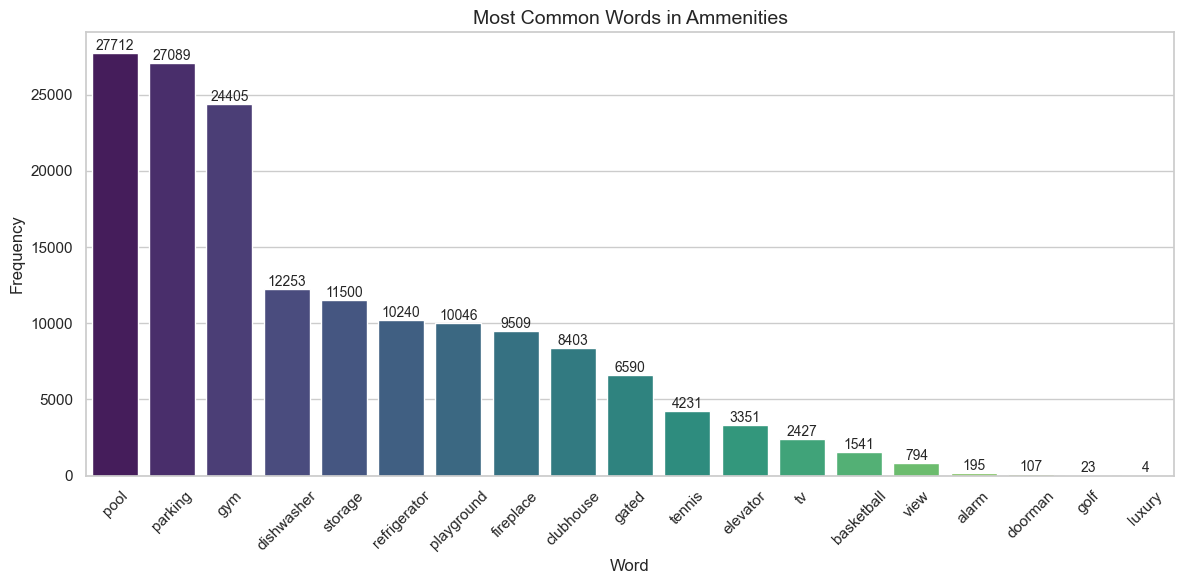

In [115]:
df['amenities_word_check'] = df['amenities'].fillna('No_Amenities')

all_words = ' '.join(df['amenities_word_check']).lower().split(',')

stop_words = set(stopwords.words('english'))
#stop_words.add('rt')  # No stop words 

filtered_words = [word for word in all_words if word.isalpha() and word not in stop_words]

word_counts = Counter(filtered_words)
common_words_df = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Frequency"])

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
barplot = sns.barplot(x='Word', y='Frequency', data=common_words_df, palette='viridis')

for i, row in common_words_df.iterrows():
    barplot.text(i, row.Frequency + 0.2, row.Frequency, ha='center', va='bottom', fontsize=10)

plt.title("Most Common Words in Ammenities", fontsize=14)
plt.xlabel("Word", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Introducing the K means but through creating each word as a column represented by 0 and 1 

In [ ]:
df['amenities_clean'] = df['amenities'].fillna('No Amenities')
df['amenities_clean'] = df['amenities_clean'].str.split(',')
df['amenities_clean'] = df['amenities_clean'].apply(
    lambda x: [a.strip().lower().replace(' ', '_') for a in x]
)

mlb = MultiLabelBinarizer()
amenities_encoded = mlb.fit_transform(df['amenities_clean'])

amenities_df = pd.DataFrame(
    amenities_encoded,
    columns=mlb.classes_,
    index=df.index
)


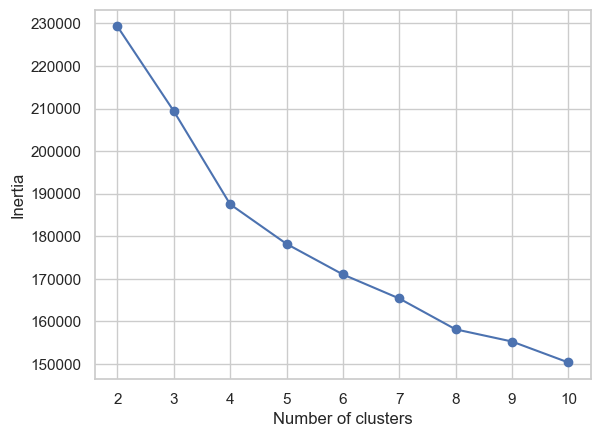

In [117]:
amenity_freq = amenities_encoded.mean(axis=0)

keep = (amenity_freq > 0.02) & (amenity_freq < 0.90)
X_filtered = amenities_encoded[:, keep]
svd = TruncatedSVD(n_components=20, random_state=42)
X_reduced = svd.fit_transform(X_filtered)
filtered_amenities = np.array(mlb.classes_)[keep]

##### plot for the cluster selection 
inertia = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_reduced)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

This is for checking the word probability in every cluster that is formed 

In [118]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['amenity_cluster'] = kmeans.fit_predict(X_reduced)

X_clustered = pd.DataFrame(
    X_filtered,
    columns=filtered_amenities
)
X_clustered['cluster'] = df['amenity_cluster']

cluster_summary = (
    X_clustered
    .groupby('cluster')
    .mean()
    .T
)

cluster_summary.sort_values(by=0, ascending=False).head(10)

cluster,0,1,2,3,4
washer_dryer,0.821083,0.130670,0.088740,0.080710,0.657333
gym,0.805773,0.088781,0.000000,0.739729,0.621670
pool,0.805697,0.188893,0.000000,0.866798,0.692655
patio/deck,0.609490,0.158417,0.087855,0.150013,0.748064
parking,0.558078,1.000000,0.000000,0.208894,0.632479
fireplace,0.494783,0.057437,0.038874,0.092461,0.323432
clubhouse,0.459517,0.044659,0.020322,0.240672,0.492638
storage,0.445502,0.274945,0.051710,0.119650,0.416376
playground,0.226978,0.048174,0.017741,0.115190,0.341646
tennis,0.198492,0.033577,0.018773,0.110044,0.168355


In [120]:
df['amenity_cluster'].value_counts()

amenity_cluster
2    27113
1    24183
3    23318
0    13129
4    11749
Name: count, dtype: int64

In [121]:
cluster_labels = {
    0: "Higher_Amenities",
    1: "Basic_Parking",
    2: "Low_Amenity",
    3: "Lifestyle_Recreation",
    4: "Family_Oriented"
}

df['amenity_segment'] = df['amenity_cluster'].map(cluster_labels)

In [122]:
df['amenity_segment'].value_counts()

amenity_segment
Low_Amenity             27113
Basic_Parking           24183
Lifestyle_Recreation    23318
Higher_Amenities        13129
Family_Oriented         11749
Name: count, dtype: int64

In [97]:
[g for g in ['golf', 'luxury'] if g in mlb.classes_]

mask = df['amenities_clean'].apply(
    lambda x: ('golf' in x) or ('luxury' in x)
)

df_special = df.loc[mask, ['amenities_clean', 'amenity_cluster']]

df_special['amenity_cluster'].value_counts()


amenity_cluster
2    209
4     23
1      4
0      1
Name: count, dtype: int64

In [98]:
df_special['amenity_segment'] = df_special['amenity_cluster'].map(cluster_labels)


In [99]:
df_special['amenity_segment'].value_counts()

amenity_segment
Low Amenity         209
Family_Oriented      23
Basic_Parking         4
Luxury_Amenities      1
Name: count, dtype: int64

<Axes: xlabel='price', ylabel='Count'>

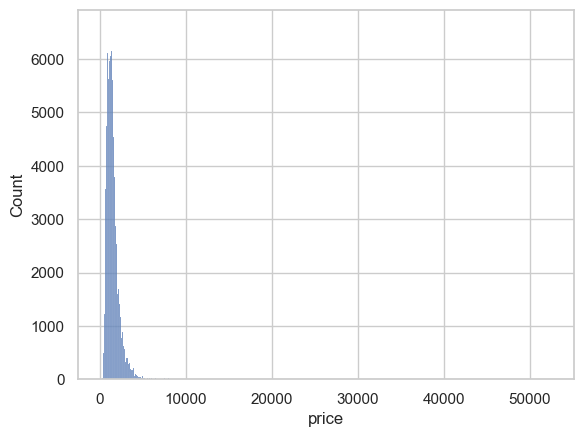

In [ ]:
### price is skewed to the right hence we need to 
sns.histplot(data=df, x="price")

In [123]:
###Check a df log transformation for this one 
df['log_price'] = np.log1p(df['price'])

segments = df['amenity_segment'].unique()

log_price_groups = [
    df.loc[df['amenity_segment'] == seg, 'log_price'].dropna()
    for seg in segments
]

from scipy.stats import f_oneway

f_stat, p_value = f_oneway(*log_price_groups)

f_stat, p_value

(np.float64(180.08746815387545), np.float64(4.968100863947623e-154))

In [102]:
df['log_price'].describe()

count    99491.000000
mean         7.226681
std          0.439049
min          4.615121
25%          6.921658
50%          7.208600
75%          7.493317
max         10.868587
Name: log_price, dtype: float64

In [145]:
df['datetime_utc'] = pd.to_datetime(df['time'], unit='s', utc=True)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    99492 non-null  int64  
 1   category              99492 non-null  object 
 2   title                 99492 non-null  object 
 3   body                  99492 non-null  object 
 4   amenities             83448 non-null  object 
 5   bathrooms             99429 non-null  float64
 6   bedrooms              99492 non-null  float64
 7   currency              99492 non-null  object 
 8   fee                   99492 non-null  object 
 9   has_photo             99492 non-null  object 
 10  pets_allowed          39068 non-null  object 
 11  price                 99491 non-null  float64
 12  price_display         99491 non-null  object 
 13  price_type            99492 non-null  object 
 14  square_feet           99492 non-null  int64  
 15  cityname           

In [129]:
df.columns

Index(['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms',
       'currency', 'fee', 'has_photo', 'pets_allowed', 'price',
       'price_display', 'price_type', 'square_feet', 'cityname', 'state',
       'latitude', 'longitude', 'source', 'time', 'amenities_word_check',
       'amenities_clean', 'amenity_cluster', 'amenity_segment', 'log_price'],
      dtype='object')

In [ ]:
df['price_type'].value_counts()

#'source' , 'price_type'
####This doesnt matter 

price_type
Monthly           99488
Weekly                3
Monthly|Weekly        1
Name: count, dtype: int64

In [147]:
pd.set_option('display.max_colwidth', None)
df['body'].head(10)

0               This unit is located at 507 & 509 Esplanade, Redondo Beach, 90277, CAMonthly rental rates range from $2195We have 1 beds units available for rent
1                 This unit is located at 146 Lochview Drive, Newport News, 23602, VAMonthly rental rates range from $1250We have 3 beds units available for rent
2                  This unit is located at 3101 Morningside Drive, Raleigh, 27607, NCMonthly rental rates range from $1395We have 3 beds units available for rent
3                This unit is located at 209 Aegean Way, Vacaville, 95687, CAMonthly rental rates range from $1600 - $1725We have 2 beds units available for rent
4    This unit is located at 4805 Marquette NE, Albuquerque, 87108, NMMonthly rental rates range from $975 - $1100We have one - two beds units available for rent
5              This unit is located at 7801 Marble NE, Albuquerque, 87110, NMMonthly rental rates range from $1250 - $1300We have 2 beds units available for rent
6        This unit is locate

In [150]:
df['bathrooms'].head(10)

0    1.0
1    1.5
2    2.0
3    1.0
4    1.0
5    1.5
6    2.0
7    2.0
8    1.0
9    2.0
Name: bathrooms, dtype: float64

<Axes: xlabel='square_feet', ylabel='Count'>

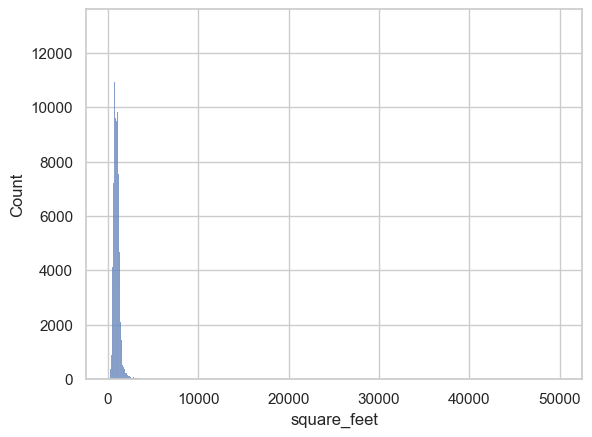

In [146]:
sns.histplot(data=df , x = 'square_feet')

In [169]:
df2 = df.copy(deep=True)
columns_drop = ['source' , 'price_type','amenities_clean','amenity_cluster','category' ,'body',
                'amenities','time','title', 'currency','amenities_word_check' ,'price_display',
                 'id' ,'cityname' ,'state','datetime_utc' ]
df2 = df2.drop(columns_drop , axis = 1)

In [166]:
df2.head()

,bathrooms,bedrooms,fee,has_photo,pets_allowed,price,square_feet,state,latitude,longitude,amenity_segment,log_price
0,1.0,1.0,No,Thumbnail,Cats,2195.0,542,CA,33.8520,-118.3759,Low_Amenity,7.694393
1,1.5,3.0,No,Thumbnail,Both,1250.0,1500,VA,37.0867,-76.4941,Low_Amenity,7.131699
2,2.0,3.0,No,Thumbnail,NaN,1395.0,1650,NC,35.8230,-78.6438,Low_Amenity,7.241366
3,1.0,2.0,No,Thumbnail,Both,1600.0,820,CA,38.3622,-121.9712,Low_Amenity,7.378384
4,1.0,1.0,No,Thumbnail,Both,975.0,624,NM,35.1038,-106.6110,Low_Amenity,6.883463


In [171]:

# Target
y = df2['log_price']

# Binary encoding
df2['fee'] = (df2['fee'] == 'Yes').astype(int)
df2['has_photo'] = (df2['has_photo'] != 'None').astype(int)

# Handle pets
df2['pets_allowed'] = df2['pets_allowed'].fillna('Not_allowed')

# Select predictors
X = df2[
    ['bathrooms', 'bedrooms', 'square_feet',
     'latitude', 'longitude',
     'fee', 'has_photo',
     'pets_allowed', 'amenity_segment']
]

# One-hot encode categoricals
X = pd.get_dummies(
    X,
    columns=['pets_allowed', 'amenity_segment'],
    drop_first=True
)


In [173]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data1 = X.copy()
data1['log_price'] = y

# Drop rows with any NaNs in predictors
data1 = data1.dropna()

# Split back
X_clean = data1.drop(columns='log_price')
y_clean = data1['log_price']

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2



(np.float64(0.39200192221972713), 0.19709822769370222)

In [174]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)

np.sqrt(mean_squared_error(y_test, pred_ridge)), r2_score(y_test, pred_ridge)


(np.float64(0.39200198085837257), 0.19709798748530916)

In [175]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

np.sqrt(mean_squared_error(y_test, pred_rf)), r2_score(y_test, pred_rf)


(np.float64(0.16612704659645922), 0.8557995180729667)

In [176]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

np.sqrt(mean_squared_error(y_test, pred_xgb)), r2_score(y_test, pred_xgb)


(np.float64(0.18875639322594792), 0.8138387168547494)

In [177]:
X_train.shape

(79522, 15)

In [178]:
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import inv_boxcox

In [185]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    #'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'bayesian ridge' : BayesianRidge(),
    'support vector': SVR(),
    'knn' : KNeighborsRegressor(n_neighbors = 4)
}

In [186]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 79522, number of used features: 12
[LightGBM] [Info] Start training from score 7.226294
lightgbm trained
gradient boosting trained
lasso trained
random forest trained
bayesian ridge trained
support vector trained
knn trained


In [187]:

from sklearn.model_selection import KFold, cross_val_score

results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
    results[name] = result

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 71569, number of used features: 12
[LightGBM] [Info] Start training from score 7.225790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 71569, number of used features: 12
[LightGBM] [Info] Start training from score 7.226044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

KeyboardInterrupt: 

In [ ]:
for name, result in results.items():
    print(f"{name} : {round(result, 3)}")